In [10]:
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold, rdScaffoldNetwork
from rdkit.Chem import rdFMCS 
from rdkit import DataStructs, Chem
from scipy.spatial.distance import squareform, cdist, pdist
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
import tmap
from faerun import Faerun
from tqdm import tqdm
from glob import glob
import os

from matplotlib.colors import ListedColormap
import matplotlib as mpl

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import numpy as np

sns.set(style = 'white', font_scale=2)


# import clsar package
import sys, os
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

from clsar.dataset import LSSNS  # dataset


In [11]:
color = sns.color_palette("jet_r", 100)
custom_cmap = ListedColormap(color[5:-5],name="custom") 

In [12]:
trp1 = ("CHEMBL3661236", "CHEMBL3661303", "CHEMBL3661302" )

trp2 = ("CHEMBL3661224", "CHEMBL3661215", "CHEMBL3665862")

In [13]:
triplets = [trp1, trp2] #, trp2

In [14]:
df = pd.read_csv('https://bidd-group.github.io/MPCD/dataset/LSSNS/BRAF.csv', 
                 index_col = 'Molecule ChEMBL ID')

In [15]:
smiles_list = df.Smiles.to_list()

dim = 2048

mols = [Chem.MolFromSmiles(s) for s in smiles_list]
ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,dim) for x in tqdm(mols, ascii=True)]
ecfps = [tmap.VectorUchar(list(fp)) for fp in ECFP4_fps]
enc = tmap.Minhash(dim, seed = 42)
lf = tmap.LSHForest(dim)
lf.batch_add(enc.batch_from_binary_array(ecfps))
lf.index()

cfg = tmap.LayoutConfiguration()
cfg.fme_randomize = False
cfg.k = 50
cfg.kc = 50
cfg.sl_scaling_min = 1.0
cfg.sl_scaling_max = 1.0
cfg.sl_repeats = 1
cfg.sl_extra_scaling_steps = 2 #2
cfg.placer = tmap.Placer.Barycenter
cfg.merger = tmap.Merger.LocalBiconnected
cfg.merger_factor = 2.0
cfg.merger_adjustment = 0
cfg.fme_iterations = 40
cfg.sl_scaling_type = tmap.ScalingType.RelativeToDesiredLength #
cfg.node_size = 1/10
cfg.mmm_repeats = 1
x, y, s, t, gp = tmap.layout_from_lsh_forest(lf, config = cfg)


100%|##############################################################################| 128/128 [00:00<00:00, 38651.61it/s]


In [16]:
dfg = pd.DataFrame([x, y]).T
dfg.columns = ['x', 'y']
dfg.index = df.index
dfg['pChEMBL'] = df['pChEMBL Value']
dfg['smiles'] = df['Smiles']
v=dfg['pChEMBL'].values

vmin = v.min()+0.2
vmax = v.max()-0.2 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet_r)
node_color=[mpl.colors.to_hex(mapper.to_rgba(i)) for i in v]


dfg['node_color'] = node_color
dfg['edgecolor'] = 'k'
dfg['linewidths'] = 0
dfg['node_size'] = 200
dfg['label'] = 'data'
dfg['alpha'] = 1
dfg['node_shape'] = 'o'

for i, triplet in enumerate(triplets):
    A = 'A%s' % (i+1)
    P = 'P%s' % (i+1)
    N = 'N%s' % (i+1)
    a, p, n = triplet

    dfg.loc[a, 'edgecolor'] = 'b'
    dfg.loc[a, 'linewidths'] = 2
    dfg.loc[a, 'node_size'] = 250
    dfg.loc[a, 'label'] = A

    dfg.loc[p, 'edgecolor'] = 'g'
    dfg.loc[p, 'linewidths'] = 2
    dfg.loc[p, 'node_size'] = 250
    dfg.loc[p, 'label'] = P

    dfg.loc[n, 'edgecolor'] = 'r'
    dfg.loc[n, 'linewidths'] = 2
    dfg.loc[n, 'node_size'] = 250
    dfg.loc[n, 'label'] = N

In [17]:
dfg1 = dfg[dfg.label == 'data']
dfg2 = dfg[dfg.label != 'data']


In [18]:
dfg.to_csv('./chemical_space.csv')

In [19]:
dfg2

,x,y,pChEMBL,smiles,node_color,edgecolor,linewidths,node_size,label,alpha,node_shape
Molecule ChEMBL ID,,,,,,,,,,,
CHEMBL3665862,-0.131540,0.369056,7.63,COc1cc(-c2ccc3ncnc(Nc4ccc(F)c(O)c4)c3c2)ccc1O,#0048ff,r,2,250,N2,1,o
CHEMBL3661302,-0.386988,0.298655,5.37,COc1cc(-c2ccc3nccc(Nc4cc(NS(C)(=O)=O)ccc4F)c3c...,#800000,r,2,250,N1,1,o
CHEMBL3661215,-0.075006,0.325931,6.08,COc1ccc(Nc2ncnc3ccc(-c4ccc(O)c(OC)c4)cc23)cc1O,#ff7700,g,2,250,P2,1,o
CHEMBL3661236,-0.311856,0.211570,6.37,COc1cc(-c2ccc3ncnc(Nc4cccc(NS(C)(=O)=O)c4)c3c2...,#ffde00,b,2,250,A1,1,o
CHEMBL3661224,-0.048207,0.311744,6.15,COc1cc(-c2ccc3ncnc(Nc4ccc5c(c4)OCO5)c3c2)ccc1O,#ff9100,b,2,250,A2,1,o
CHEMBL3661303,-0.349632,0.270636,6.57,COc1cc(-c2ccc3ncnc(Nc4cc(NS(C)(=O)=O)ccc4F)c3c...,#ceff29,g,2,250,P1,1,o


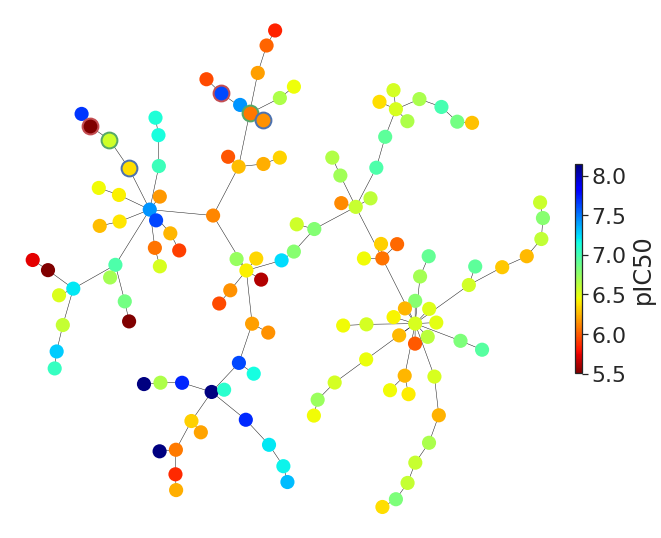

In [20]:
pos = {}
for i, j in dfg.iterrows():
    pos.update({i:j.loc[['x','y']].values})
edgelist = [(dfg.iloc[i].name,dfg.iloc[j].name) for i, j in zip(s,t)]


fig, ax = plt.subplots(figsize=(10,8))

G = nx.Graph()

nx.draw_networkx_nodes(G, pos=pos, ax = ax, 
                       node_size=dfg1.node_size.values, 
                       nodelist=dfg1.index.values, 
                       node_color = dfg1.node_color.values,
                       edgecolors = dfg1.edgecolor.values,
                       linewidths = dfg1.linewidths.values,
                       alpha = dfg1.alpha.values,
                       node_shape = 'o',
                       )

for i in range(len(dfg2)):
    ts = dfg2.iloc[[i]]
    nx.draw_networkx_nodes(G, pos=pos, ax = ax, 
                           node_size = ts.node_size.values, 
                           nodelist=ts.index.values, 
                           node_color = ts.node_color.values,
                           edgecolors = ts.edgecolor.values,
                           linewidths = ts.linewidths.values,
                           alpha = ts.alpha.values,
                           node_shape = 'o',
                           #label=ts.label.iloc[0]
                           )

nx.draw_networkx_edges(G, pos=pos, 
                       edgelist = edgelist, 
                       ax = ax, width=0.5, 
                       edge_color='k')

#plt.legend(loc='center')
#ax.legend(scatterpoints = 1, loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_facecolor("k")

sm = plt.cm.ScalarMappable(cmap='jet_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax =ax, aspect = 30, shrink = 0.4, pad = 0.01, )
cbar.set_label('pIC50')
cbar.ax.yaxis.set_ticks([5.5, 6, 6.5, 7., 7.5, 8])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.tight_layout()

fig.savefig('./braf_chemical_space.pdf', dpi = 300, bbox_inches='tight')

In [21]:
dfd = dfg2.reset_index().set_index('label').loc[['A1', 'P1', 'N1', 'A2', 'P2', 'N2']]

In [22]:
from rdkit import Chem
from rdkit.Chem import Draw
import cairosvg

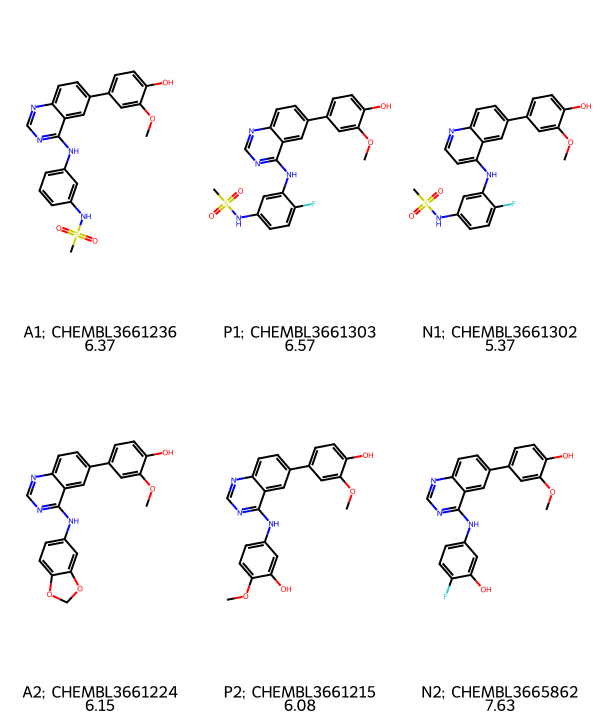

In [23]:
ms = [Chem.MolFromSmiles(smi) for smi in dfd.smiles]
labels = (dfd.index+'; ' + dfd['Molecule ChEMBL ID'] + '\n' + dfd.pChEMBL.astype(str)).to_list()

patt = Chem.MolFromSmiles('COc1cc(ccc1O)-c1ccccc1')
AllChem.Compute2DCoords(patt)
for m in ms: AllChem.GenerateDepictionMatching2DStructure(m,patt)


img = Draw.MolsToGridImage(ms, useSVG=True, molsPerRow=3, 
                           legends = labels,
                           subImgSize=(200, 360))
cairosvg.svg2pdf(bytestring=img.data.encode(),
                 
                 write_to='braf_2_triplets.pdf')

img

In [24]:
dfd

,Molecule ChEMBL ID,x,y,pChEMBL,smiles,node_color,edgecolor,linewidths,node_size,alpha,node_shape
label,,,,,,,,,,,
A1,CHEMBL3661236,-0.311856,0.211570,6.37,COc1cc(-c2ccc3ncnc(Nc4cccc(NS(C)(=O)=O)c4)c3c2...,#ffde00,b,2,250,1,o
P1,CHEMBL3661303,-0.349632,0.270636,6.57,COc1cc(-c2ccc3ncnc(Nc4cc(NS(C)(=O)=O)ccc4F)c3c...,#ceff29,g,2,250,1,o
N1,CHEMBL3661302,-0.386988,0.298655,5.37,COc1cc(-c2ccc3nccc(Nc4cc(NS(C)(=O)=O)ccc4F)c3c...,#800000,r,2,250,1,o
A2,CHEMBL3661224,-0.048207,0.311744,6.15,COc1cc(-c2ccc3ncnc(Nc4ccc5c(c4)OCO5)c3c2)ccc1O,#ff9100,b,2,250,1,o
P2,CHEMBL3661215,-0.075006,0.325931,6.08,COc1ccc(Nc2ncnc3ccc(-c4ccc(O)c(OC)c4)cc23)cc1O,#ff7700,g,2,250,1,o
N2,CHEMBL3665862,-0.131540,0.369056,7.63,COc1cc(-c2ccc3ncnc(Nc4ccc(F)c(O)c4)c3c2)ccc1O,#0048ff,r,2,250,1,o
